In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from kerastuner import RandomSearch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import Precision

/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_39502/3088537827.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
num_classes = 2

# Image Data Generators for augmenting and rescaling images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
# Load training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # VGG16 expects 224x224 images
    batch_size=32,
    class_mode='categorical'  # Categorical for multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 194 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [5]:
number_of_class = 2

In [6]:
def build_model(hp):
    # Load the base VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    # Add custom layers on top
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Use Global Average Pooling to reduce dimensionality before the dense layers
    x = GlobalAveragePooling2D()(x)

    # Add fully connected layers with Dropout for regularization
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(number_of_class, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with tunable optimizer and learning rate
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
# Initialize Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train with each combination
    directory='tuner_results',
    project_name='vgg16_tuning'
)

In [8]:
number_of_epochs = 30

In [9]:
# Run the hyperparameter search
tuner.search(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Trial 2 Complete [00h 04m 04s]
val_accuracy: 0.6071428656578064

Best val_accuracy So Far: 0.6071428656578064
Total elapsed time: 00h 08m 09s


In [10]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# Optional: Evaluate the best model on the validation set
loss, accuracy = best_model.evaluate(val_generator)
print(f"Best model validation loss: {loss}")
print(f"Best model validation accuracy: {accuracy}")

Best Hyperparameters:
{'optimizer': 'sgd'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6071 - loss: 0.6813
Best model validation loss: 0.6812920570373535
Best model validation accuracy: 0.6071428656578064


In [11]:
best_model.compile(
    optimizer=best_hyperparameters.get('optimizer'),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision')]
)

In [12]:
history = best_model.fit(
    train_generator,
    epochs=number_of_epochs,
    validation_data=val_generator
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step - accuracy: 0.5247 - loss: 0.8748 - precision: 0.5247 - val_accuracy: 0.3929 - val_loss: 0.7061 - val_precision: 0.3929
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.5646 - loss: 0.6864 - precision: 0.5646 - val_accuracy: 0.4286 - val_loss: 0.7401 - val_precision: 0.4286
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.6049 - loss: 0.7111 - precision: 0.6049 - val_accuracy: 0.3929 - val_loss: 0.6958 - val_precision: 0.3929
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.5695 - loss: 0.7888 - precision: 0.5695 - val_accuracy: 0.4286 - val_loss: 0.7049 - val_precision: 0.4286
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.5820 - loss: 0.7017 - precision: 0.5820 - val_accuracy: 0.4286 - val_loss: 0.7389 - val_precision: 0.4286
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.6966 - loss: 0.6384 - precision: 0.6966 - val_accuracy: 0.3929 - val_loss: 0.7158 - va

In [13]:
# Save the model, optional
best_model.save(f'Pth_Files/VGG16_{number_of_epochs}.keras')

In [14]:
predictions = best_model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())  # Get class labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


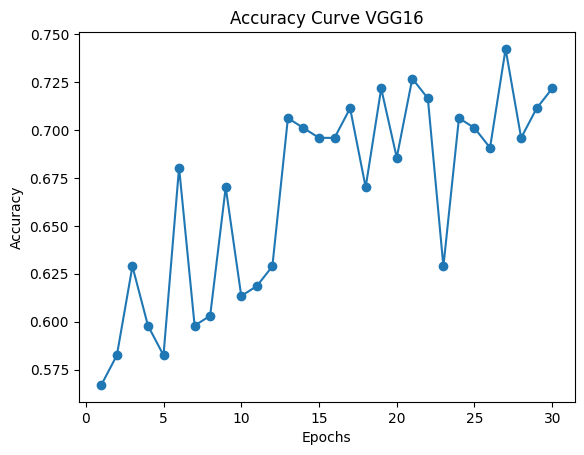

In [15]:
# Plot accuracy and precision curves
epochs = range(1, number_of_epochs + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']

plt.plot(epochs, train_acc, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve VGG16')
plt.show()

In [16]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')  # 'weighted' to handle class imbalance
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Create a DataFrame to display statistics
stats_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [accuracy, precision, recall, f1]
})

# Display the DataFrame
print(stats_df)

      Metric     Value
0   Accuracy  0.392857
1  Precision  0.174603
2     Recall  0.392857
3   F1-Score  0.241758


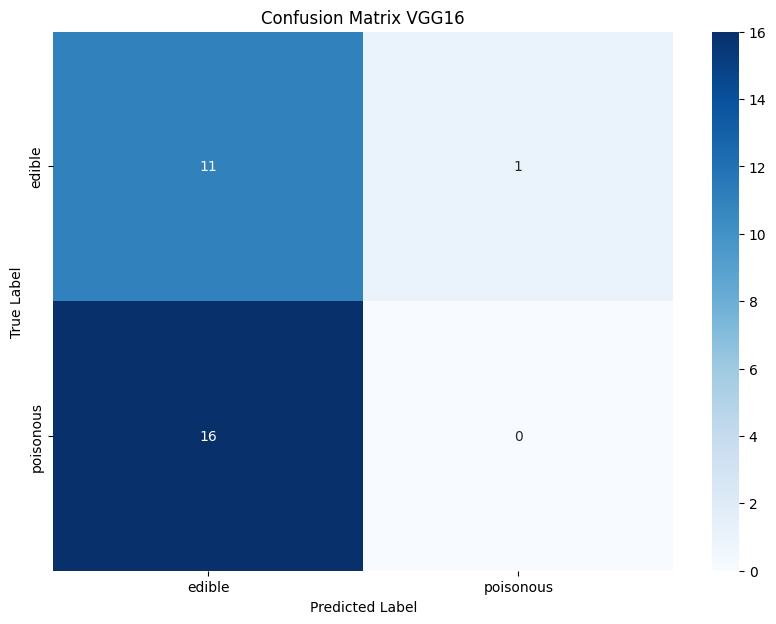

In [17]:
plt.figure(figsize=(10, 7))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix VGG16')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()